In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['agg.path.chunksize'] = 10000

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [172]:
test = pd.read_csv('G:/내 드라이브/취업/Contest/2307_PublicData/data/test_data.csv', sep=',', index_col=0)
df = pd.read_csv('G:/내 드라이브/취업/Contest/2307_PublicData/data/final_ver1.csv', sep=',', index_col=0)
ml_test = pd.read_csv('G:/내 드라이브/취업/Contest/2307_PublicData/data/lgbm_test_v1.csv', sep=',', index_col=0)

In [44]:
def result_graph(actual, predicted):
    
    MAPE = np.mean(np.abs((actual - predicted) / actual)) * 100

    # MAPE 계산
    mape = [abs((a - p) / a) * 100 for a, p in zip(actual, predicted)]
    
    print('MAPE : ', MAPE)

    # 그래프 크기 설정
    fig = plt.figure(figsize=(10, 6))

    # 그래프 그리기
    plt.plot(mape)
    plt.xlabel('Data Point')
    plt.ylabel('MAPE (%)')
    plt.title('MAPE Ratio')
    plt.show()
    
    fig = plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='actual')
    plt.plot(pred, label='pred')
    plt.title('Actual & Predict')
    plt.legend()
    plt.show()

In [4]:
y_test = test['현재수요(MW)']

In [ ]:
# 정상성 검증

# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf

for i in df.columns:
    plot_acf(df[i], lags=50)
    plt.title('ACF for %s' % i)
    plt.show()

In [ ]:
# check stationary: mean, variance(std)and adfuller test

check_adfuller(df['기온(°C)'])

# Linear Regression, Sliding Window

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Sliding window 크기와 예측할 시간 간격 설정
window_size = 12  # 예시로 12개의 데이터로 sliding window를 구성
prediction_interval = 72  # 예시로 3개의 데이터 후 값을 예측

# 예측 결과를 저장할 리스트
predictions = []

# Sliding window 방식으로 시계열 예측
for i in range(len(df) - window_size - prediction_interval + 1):
    # Sliding window의 시작과 끝 인덱스
    start_index = i
    end_index = i + window_size
    
    # Sliding window 데이터 구성
    window_data = df.iloc[start_index:end_index]
    
    # Features와 Target 분리
    X = window_data[:-prediction_interval].values.reshape(-1, 1)
    y = window_data[-prediction_interval:].values.reshape(-1, 1)
    
    # 선형 회귀 모델 학습
    model = LinearRegression()
    model.fit(X, y)
    
    # 다음 값을 예측하여 리스트에 추가
    next_x = window_data[-1:].values.reshape(-1, 1)
    next_prediction = model.predict(next_x)
    predictions.append(next_prediction)

# 예측 결과 출력
print("다음", prediction_interval, "개의 값 예측:")
for prediction in predictions:
    print(prediction.flatten())

# VAR

In [6]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [7]:
# VAR 모델 피팅
model_var = VAR(df)

c:\python38-64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\python38-64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
res = model_var.select_order(3)
res.summary()

,AIC,BIC,FPE,HQIC
0,35.42,35.42,2.405e+15,35.42
1,-99.59,-99.59,5.579e-44,-99.59
2,-134.2,-134.1,5.464e-59,-134.2
3,-134.2*,-134.2*,5.039e-59*,-134.2*


In [46]:
model_var_fit = model_var.fit(maxlags=10, ic='aic')
lag_order = model_var_fit.k_ar
lag_order

10

In [47]:
pred = []

for i in model_var_fit.forecast(df.values[-lag_order:], steps=2016):
    pred.append(i[-1])

MAPE :  9.862603952079665


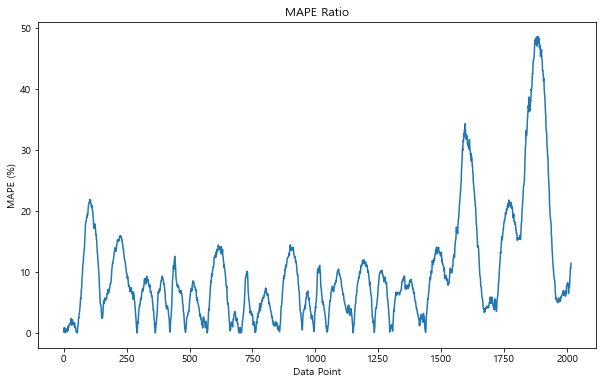

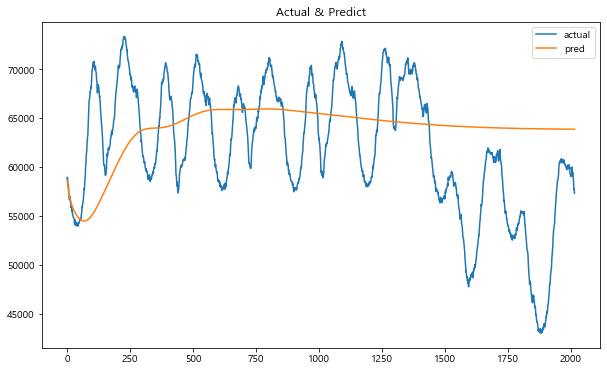

In [48]:
result_graph(y_test.values, pred)

# LGBM

In [90]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer  # loss function 커스터마이징

In [140]:
#시간 변수와 요일 변수

def time(x):
    return int(x[-5:-3])

# 분 단위 위치 바꼈을 때
def time2(x):
    return int(x[-2:])

def weekday(x):
    return pd.to_datetime(x[:10]).weekday()

# 파라미터 설정, 모델생성 함수
def get_best_params(model, params):
    grid_model = GridSearchCV(
        model,
        param_grid = params,  # 파라미터
        cv = 5,  # Kfold : 5
        scoring= SMAPE)  #loss function

    grid_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=100)
    scr = grid_model.best_score_
    print(f'{model.__class__.__name__} 최적 score 값 {scr}')
    return grid_model.best_estimator_

def smape(true, pred):
    true = np.array(true)  # np.array로 바꿔야 에러 없음
    pred = np.array(pred)
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))  # *2 , *100은 상수이므로 생략
SMAPE = make_scorer(smape, greater_is_better=False)  # smape 값이 작아져야하므로 False

In [174]:
df = df.reset_index()
df['time'] = df['기준일시'].apply(lambda x : time2(x))
df['weekday'] = df['기준일시'].apply(lambda x : weekday(x))
df.drop('기준일시', axis=1, inplace=True)

In [175]:
X = df.drop('현재수요(MW)', axis=1)
y = df['현재수요(MW)']

In [176]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=44)

In [177]:
params = {'n_estimators' : [30, 100, 200, 500],
          'learning_rate' : [0.01, 0.1],
          'objective' : ['regression'],
          'boosting_type' : ['gbdt'],
          'max_depth' : [1, 3, 5], # 나무의 깊이
          'subsample' : [0.5, 1]
         }


In [178]:
model = LGBMRegressor(params)

In [179]:
# 학습진행
best_lgbm = get_best_params(model, params)
best_lgbm 

[100]	valid_0's l2: 5.78838e+07	valid_1's l2: 5.80282e+07
[100]	valid_0's l2: 5.78746e+07	valid_1's l2: 5.80195e+07
[100]	valid_0's l2: 5.78794e+07	valid_1's l2: 5.80263e+07
[100]	valid_0's l2: 5.78676e+07	valid_1's l2: 5.80145e+07
[100]	valid_0's l2: 5.78664e+07	valid_1's l2: 5.80131e+07
[100]	valid_0's l2: 5.78838e+07	valid_1's l2: 5.80282e+07
[100]	valid_0's l2: 5.78746e+07	valid_1's l2: 5.80195e+07
[100]	valid_0's l2: 5.78794e+07	valid_1's l2: 5.80263e+07
[100]	valid_0's l2: 5.78676e+07	valid_1's l2: 5.80145e+07
[100]	valid_0's l2: 5.78664e+07	valid_1's l2: 5.80131e+07
[100]	valid_0's l2: 5.78838e+07	valid_1's l2: 5.80282e+07
[200]	valid_0's l2: 5.01493e+07	valid_1's l2: 5.02795e+07
[100]	valid_0's l2: 5.78746e+07	valid_1's l2: 5.80195e+07
[200]	valid_0's l2: 5.01462e+07	valid_1's l2: 5.02776e+07
[100]	valid_0's l2: 5.78794e+07	valid_1's l2: 5.80263e+07
[200]	valid_0's l2: 5.0149e+07	valid_1's l2: 5.02807e+07
[100]	valid_0's l2: 5.78676e+07	valid_1's l2: 5.80145e+07
[200]	valid_0's

[300]	valid_0's l2: 3.03507e+07	valid_1's l2: 3.04494e+07
[400]	valid_0's l2: 2.90327e+07	valid_1's l2: 2.91334e+07
[500]	valid_0's l2: 2.83183e+07	valid_1's l2: 2.84229e+07
[100]	valid_0's l2: 4.10223e+07	valid_1's l2: 4.11358e+07
[200]	valid_0's l2: 3.32995e+07	valid_1's l2: 3.34015e+07
[300]	valid_0's l2: 3.03504e+07	valid_1's l2: 3.045e+07
[400]	valid_0's l2: 2.90168e+07	valid_1's l2: 2.91166e+07
[500]	valid_0's l2: 2.82984e+07	valid_1's l2: 2.84018e+07
[100]	valid_0's l2: 4.10354e+07	valid_1's l2: 4.11499e+07
[200]	valid_0's l2: 3.33039e+07	valid_1's l2: 3.34066e+07
[300]	valid_0's l2: 3.03479e+07	valid_1's l2: 3.04515e+07
[400]	valid_0's l2: 2.90382e+07	valid_1's l2: 2.91465e+07
[500]	valid_0's l2: 2.83117e+07	valid_1's l2: 2.84215e+07
[100]	valid_0's l2: 4.10449e+07	valid_1's l2: 4.11573e+07
[200]	valid_0's l2: 3.33102e+07	valid_1's l2: 3.34108e+07
[300]	valid_0's l2: 3.03642e+07	valid_1's l2: 3.04636e+07
[400]	valid_0's l2: 2.90485e+07	valid_1's l2: 2.9152e+07
[500]	valid_0's l

[500]	valid_0's l2: 3.01615e+07	valid_1's l2: 3.02487e+07
[100]	valid_0's l2: 3.39503e+07	valid_1's l2: 3.4061e+07
[200]	valid_0's l2: 3.16132e+07	valid_1's l2: 3.17102e+07
[300]	valid_0's l2: 3.08542e+07	valid_1's l2: 3.09428e+07
[400]	valid_0's l2: 3.04335e+07	valid_1's l2: 3.05183e+07
[500]	valid_0's l2: 3.01515e+07	valid_1's l2: 3.02363e+07
[100]	valid_0's l2: 3.39718e+07	valid_1's l2: 3.40845e+07
[200]	valid_0's l2: 3.16367e+07	valid_1's l2: 3.17334e+07
[300]	valid_0's l2: 3.08716e+07	valid_1's l2: 3.09593e+07
[400]	valid_0's l2: 3.04474e+07	valid_1's l2: 3.05347e+07
[500]	valid_0's l2: 3.0164e+07	valid_1's l2: 3.02504e+07
[100]	valid_0's l2: 3.39596e+07	valid_1's l2: 3.4074e+07
[200]	valid_0's l2: 3.16221e+07	valid_1's l2: 3.17216e+07
[300]	valid_0's l2: 3.08632e+07	valid_1's l2: 3.09543e+07
[400]	valid_0's l2: 3.04415e+07	valid_1's l2: 3.05305e+07
[500]	valid_0's l2: 3.01581e+07	valid_1's l2: 3.02447e+07
[100]	valid_0's l2: 3.39611e+07	valid_1's l2: 3.40724e+07
[200]	valid_0's l

[100]	valid_0's l2: 2.12567e+07	valid_1's l2: 2.13921e+07
[200]	valid_0's l2: 1.83433e+07	valid_1's l2: 1.85009e+07
[100]	valid_0's l2: 2.13825e+07	valid_1's l2: 2.15113e+07
[200]	valid_0's l2: 1.84326e+07	valid_1's l2: 1.85967e+07
[100]	valid_0's l2: 2.11728e+07	valid_1's l2: 2.12943e+07
[200]	valid_0's l2: 1.82721e+07	valid_1's l2: 1.84299e+07
[300]	valid_0's l2: 1.63661e+07	valid_1's l2: 1.65835e+07
[400]	valid_0's l2: 1.5083e+07	valid_1's l2: 1.53366e+07
[500]	valid_0's l2: 1.39917e+07	valid_1's l2: 1.42875e+07
[100]	valid_0's l2: 2.12107e+07	valid_1's l2: 2.13275e+07
[200]	valid_0's l2: 1.83681e+07	valid_1's l2: 1.85237e+07
[300]	valid_0's l2: 1.64164e+07	valid_1's l2: 1.66286e+07
[400]	valid_0's l2: 1.50031e+07	valid_1's l2: 1.5257e+07
[500]	valid_0's l2: 1.39305e+07	valid_1's l2: 1.42118e+07
[100]	valid_0's l2: 2.13153e+07	valid_1's l2: 2.14514e+07
[200]	valid_0's l2: 1.83293e+07	valid_1's l2: 1.84869e+07
[300]	valid_0's l2: 1.63902e+07	valid_1's l2: 1.65952e+07
[400]	valid_0's 

LGBMRegressor(max_depth=5, n_estimators=500, objective='regression',
              subsample=0.5)

In [180]:
y_pred = best_lgbm.predict(X_train)

In [181]:
y_pred

array([64902.71738799, 60828.33811597, 57603.25831102, ...,
       51018.13734507, 69354.28852169, 68681.2112135 ])

In [182]:
print(y_train.shape)
print(y_pred.shape)

(792692,)
(792692,)


MAPE :  4.576717426776724


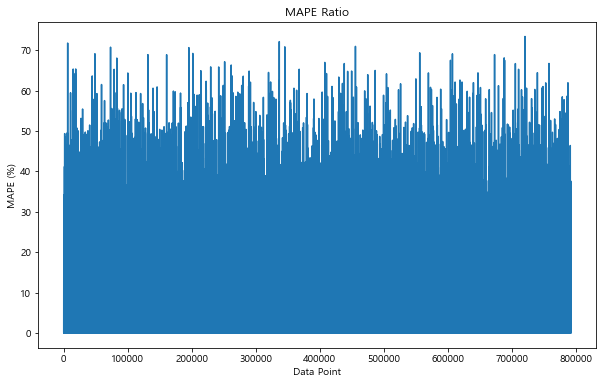

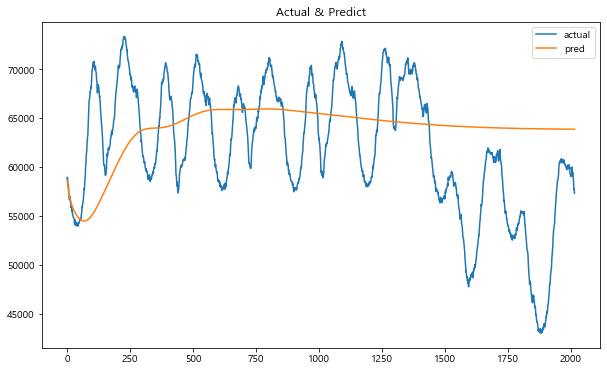

In [183]:
result_graph(y_train, y_pred)

In [184]:
ml_test = ml_test.reset_index()
ml_test['time'] = ml_test['기준일시'].apply(lambda x : time(x))
ml_test['weekday'] = ml_test['기준일시'].apply(lambda x : weekday(x))
ml_test.drop(['기준일시','pred'], axis=1, inplace=True)
# ml_test.drop(['level_0', 'index'], axis=1, inplace=True)

In [185]:
ml_test

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa),적설(cm),지면온도(°C),5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),time,weekday
0,1.540000,0.487500,4.997895,288.842105,45.505263,3.140000,-9.144211,1010.333684,1023.246316,0.650000,0.937895,6.017241,7.651724,9.251724,9.768966,0,0
1,1.500702,0.446875,4.975000,288.517544,45.326316,3.119474,-9.228860,1010.354825,1023.269825,0.634722,0.895351,5.969540,7.615517,9.229023,9.756322,5,0
2,1.461404,0.406250,4.952105,288.192982,45.147368,3.098947,-9.313509,1010.375965,1023.293333,0.619444,0.852807,5.921839,7.579310,9.206322,9.743678,10,0
3,1.422105,0.365625,4.929211,287.868421,44.968421,3.078421,-9.398158,1010.397105,1023.316842,0.604167,0.810263,5.874138,7.543103,9.183621,9.731034,15,0
4,1.382807,0.325000,4.906316,287.543860,44.789474,3.057895,-9.482807,1010.418246,1023.340351,0.588889,0.767719,5.826437,7.506897,9.160920,9.718391,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,5.481053,0.000000,0.849474,127.473684,66.294737,5.940000,-0.705263,1006.310526,1018.981053,0.000000,4.141053,9.117241,10.234483,10.765517,10.451724,35,6
2012,5.481053,0.000000,0.849474,127.473684,66.294737,5.940000,-0.705263,1006.310526,1018.981053,0.000000,4.141053,9.117241,10.234483,10.765517,10.451724,40,6
2013,5.481053,0.000000,0.849474,127.473684,66.294737,5.940000,-0.705263,1006.310526,1018.981053,0.000000,4.141053,9.117241,10.234483,10.765517,10.451724,45,6
2014,5.481053,0.000000,0.849474,127.473684,66.294737,5.940000,-0.705263,1006.310526,1018.981053,0.000000,4.141053,9.117241,10.234483,10.765517,10.451724,50,6


In [186]:
y_pred = best_lgbm.predict(ml_test)

In [165]:
print(y_test.shape)
print(y_pred.shape)

(2016,)
(2016,)


MAPE :  5.637841350643793


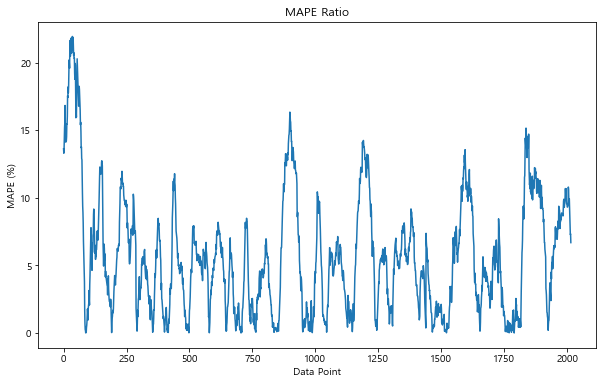

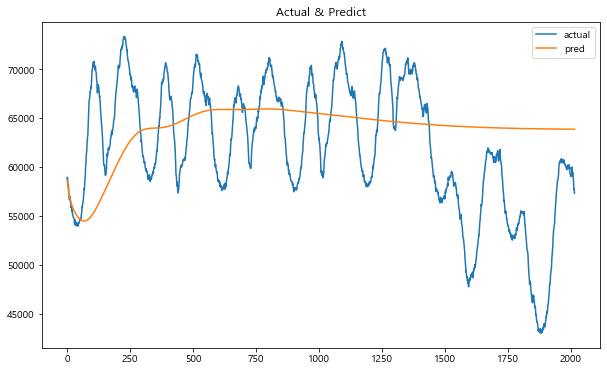

In [187]:
result_graph(y_test, y_pred)

# LSTM

# Temporal Fusion Transformer